In [1]:
import datetime
import pandas as pd
import numpy as np
import subprocess

from google.colab import data_table
data_table.enable_dataframe_formatter()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8')
#plt.style.use('Solarize_Light2')

In [4]:
# First, we'll read the provided labeled training data
xl_url = '/content/drive/MyDrive/MMAI_831/ADAS16/Dataset.xlsx'
df = pd.read_excel(xl_url, sheet_name='Format')

#Favourite and Least Favourite Words EDA

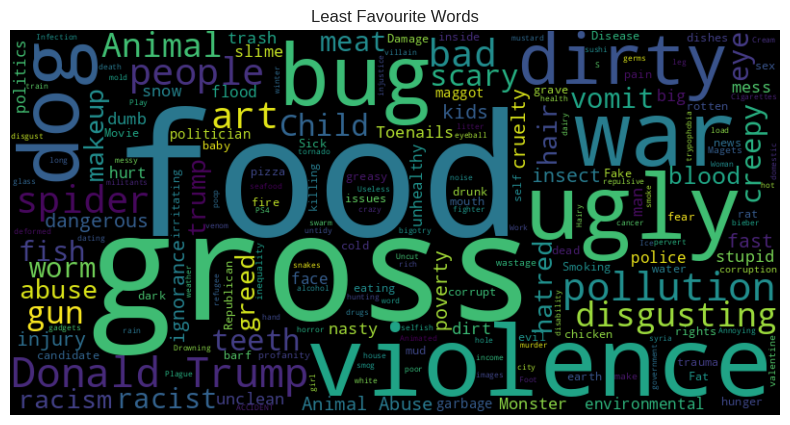

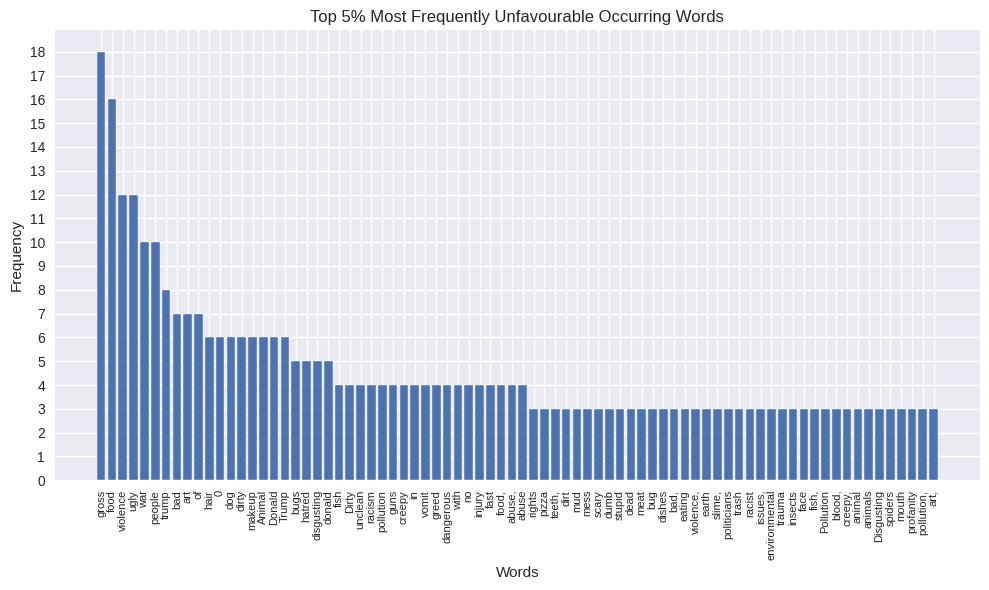

In [13]:
from wordcloud import WordCloud
from collections import Counter

unfave_df = pd.DataFrame()
# Select the column you want to generate a word cloud from
selected_columns = ['unfave1-descr', 'unfave2-descr', 'unfave3-descr','unfave4-descr','unfave5-descr']
# Concatenate the selected columns into a single column
unfave_df['combined_column'] = df[selected_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
text = ' '.join(unfave_df['combined_column'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title('Least Favourite Words')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Historgram of the word frequency
words = text.split()
# Count the frequency of each word
word_counts = Counter(words)
# Determine the threshold for the top 10% most frequent words
total_words = len(words)
threshold = int(total_words * 0.05)
# Extract the top 10% most frequent words and their frequencies
top_words = dict(word_counts.most_common(threshold))
# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel('Frequency')
plt.yticks(range(max(top_words.values()) + 1))
plt.title('Top 5% Most Frequently Unfavourable Occurring Words')
plt.tight_layout()
plt.show()

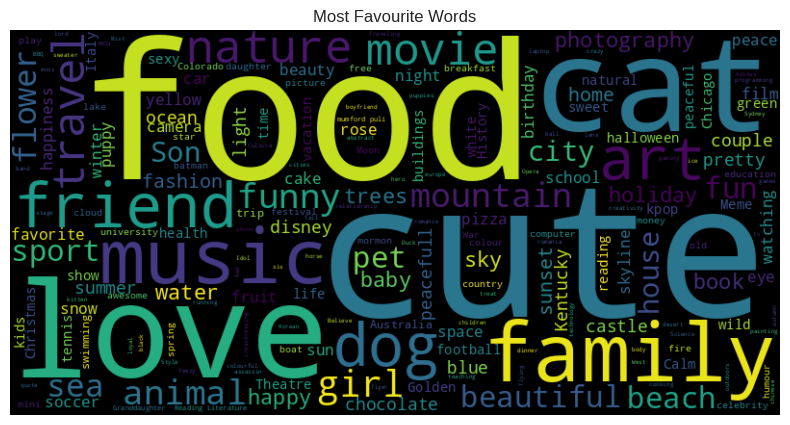

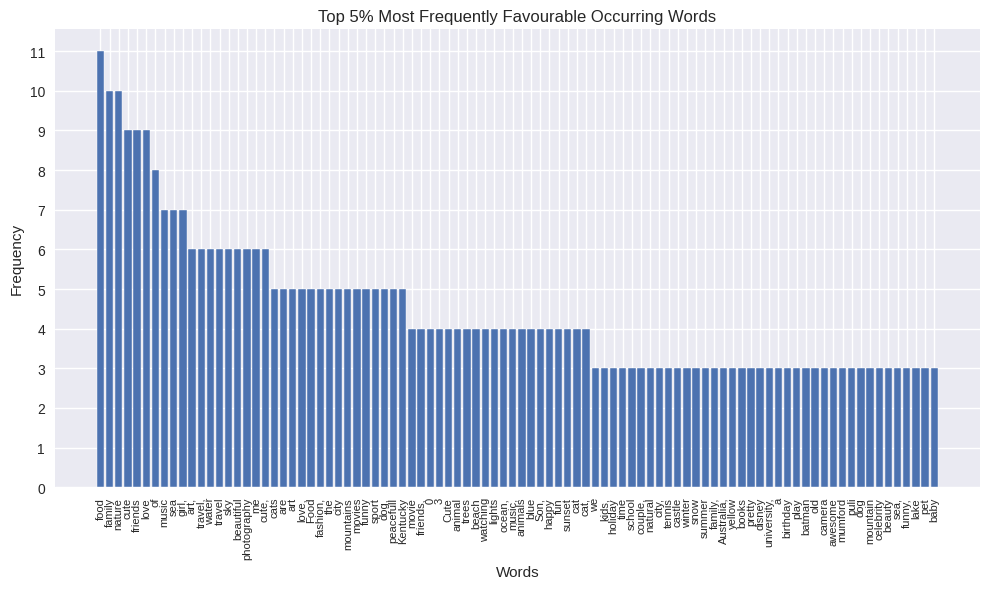

In [14]:
fave_df = pd.DataFrame()
# Select the column you want to generate a word cloud from
selected_columns = ['fave1-descr', 'fave2-descr', 'fave3-descr','fave4-descr','fave5-descr']
# Concatenate the selected columns into a single column
fave_df['combined_column'] = df[selected_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

text = ' '.join(fave_df['combined_column'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title('Most Favourite Words')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

conjunctions = ['and', 'but', 'or', 'nor', 'so', 'yet', 'my', 'in']  # Add more if needed
# Remove conjunctions from the text
text = ' '.join([word for word in text.split() if word.lower() not in conjunctions])

#Historgram of the word frequency
words = text.split()
# Count the frequency of each word
word_counts = Counter(words)
# Determine the threshold for the top 10% most frequent words
total_words = len(words)
threshold = int(total_words * 0.05)
# Extract the top 10% most frequent words and their frequencies
top_words = dict(word_counts.most_common(threshold))
# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.xticks(rotation='vertical', fontsize=8)
plt.ylabel('Frequency')
plt.yticks(range(max(top_words.values()) + 1))
plt.title('Top 5% Most Frequently Favourable Occurring Words')
plt.tight_layout()
plt.show()

#OCEAN Personality EDA

In [15]:
ocean_df = pd.DataFrame()
# Select the columns we want for each user
selected_columns = ['Q 1', 'Q 2','Q 3','Q 4','Q 5','Q 6','Q 7','Q 8', 'Q 9','Q 10']
# Create the new DataFrame with the selected columns
ocean_df = df[selected_columns].copy()
ocean_df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)
ocean_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
0,1,2,-2,0,-1,0,-2,2,-1,1
1,2,0,2,-2,-1,-1,2,0,2,1
2,-1,2,0,2,0,2,-1,2,-1,2
3,1,1,-1,0,-1,0,-1,1,0,1
4,1,2,1,1,-1,0,0,2,0,2


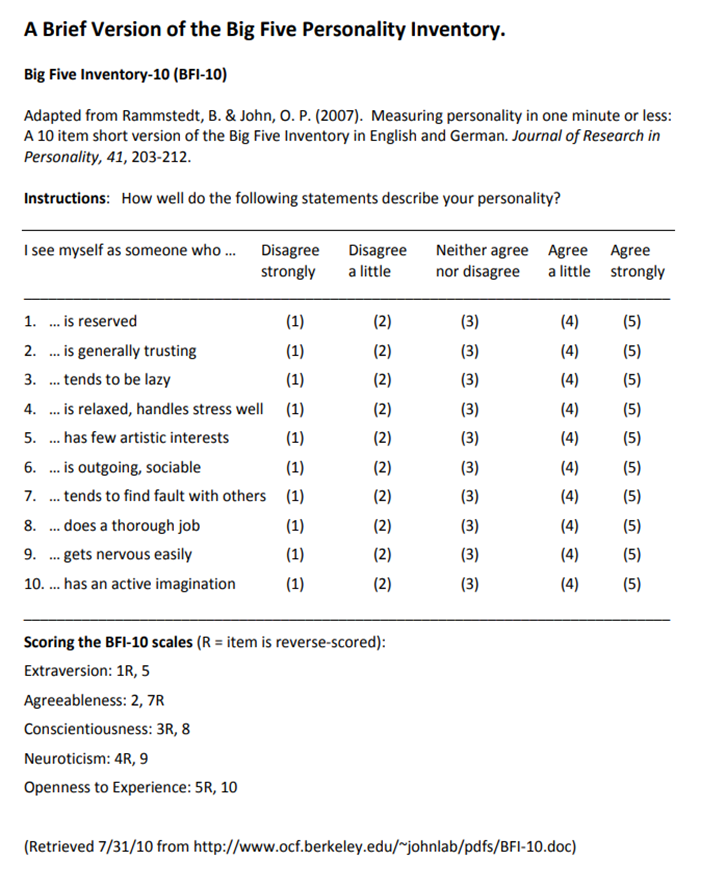

In [16]:
# Define the questions corresponding to each OCEAN dimension
ocean_questions = {
    'Openness': ['Q1', 'Q2'],
    'Conscientiousness': ['Q3', 'Q4'],
    'Extraversion': ['Q5', 'Q6'],
    'Agreeableness': ['Q7', 'Q8'],
    'Neuroticism': ['Q9', 'Q10']
}

#Questions with reverse scoring
ocean_df['Q1'] *= -1
ocean_df['Q3'] *= -1
ocean_df['Q4'] *= -1
ocean_df['Q5'] *= -1
ocean_df['Q7'] *= -1

# Step 2: Calculate Trait Scores
# Calculate the scores for each trait based on the responses to the relevant questions
ocean_df['openness_score'] = ocean_df['Q1'] + ocean_df['Q5']
ocean_df['conscientiousness_score'] = ocean_df['Q3'] + ocean_df['Q8']
ocean_df['extraversion_score'] = ocean_df['Q1']+ ocean_df['Q5']
ocean_df['agreeableness_score'] = ocean_df['Q2']+ ocean_df['Q7']
ocean_df['neuroticism_score'] = ocean_df['Q4']+ ocean_df['Q9']

user_ratings_df = pd.DataFrame()
user_ratings_df['openness_rating'] = (ocean_df['openness_score'] + 4) * (5 / 8)
user_ratings_df['conscientiousness_rating'] = (ocean_df['conscientiousness_score'] + 4) * (5 / 8)
user_ratings_df['extraversion_rating'] = (ocean_df['extraversion_score'] + 4) * (5 / 8)
user_ratings_df['agreeableness_rating'] = (ocean_df['Q7'] + ocean_df['Q8'] + 4) * (5 / 8)
user_ratings_df['neuroticism_rating'] = (ocean_df['Q9'] + ocean_df['Q10'] + 4) * (5 / 8)

ocean_df = ocean_df.drop('openness_score', axis=1)
ocean_df = ocean_df.drop('conscientiousness_score', axis=1)
ocean_df = ocean_df.drop('extraversion_score', axis=1)
ocean_df = ocean_df.drop('agreeableness_score', axis=1)
ocean_df = ocean_df.drop('neuroticism_score', axis=1)

#ocean_df
user_ratings_df

,openness_rating,conscientiousness_rating,extraversion_rating,agreeableness_rating,neuroticism_rating
0,2.500,5.000,2.500,5.000,2.500
1,1.875,1.250,1.875,1.250,4.375
2,3.125,3.750,3.125,4.375,3.125
3,2.500,3.750,2.500,3.750,3.125
4,2.500,3.125,2.500,3.750,3.750
...,...,...,...,...,...
115,2.500,2.500,2.500,1.875,3.125
116,1.875,5.000,1.875,4.375,1.250
117,1.875,1.250,1.875,2.500,3.750
118,2.500,3.750,2.500,2.500,3.750


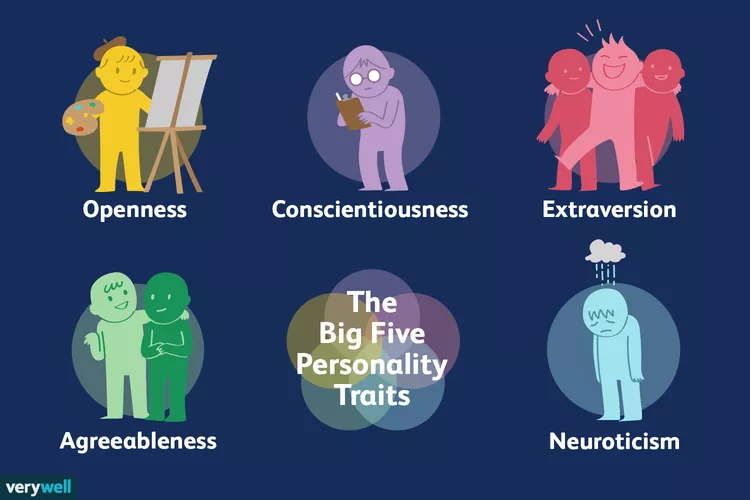

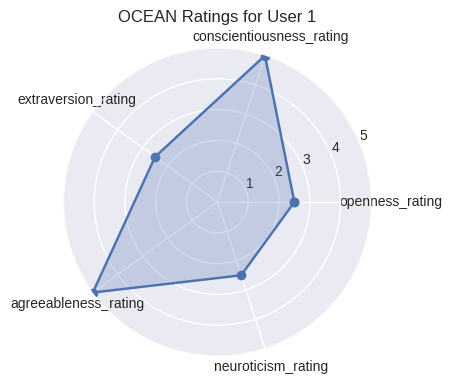

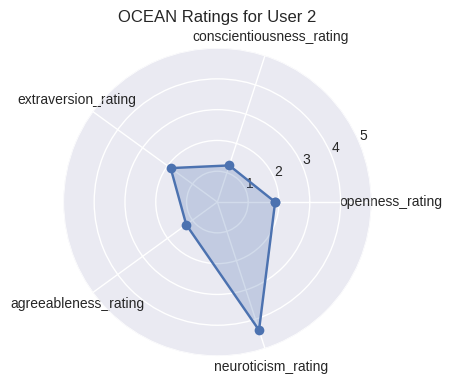

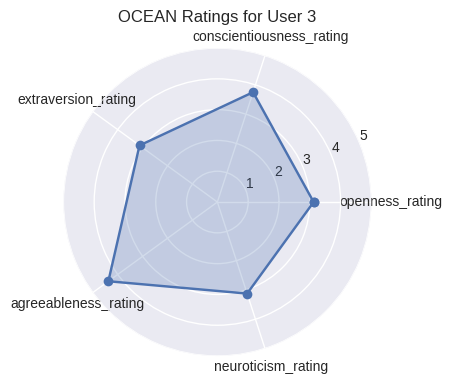

In [17]:
# Define the OCEAN dimensions
dimensions = ['openness_rating', 'conscientiousness_rating', 'extraversion_rating', 'agreeableness_rating', 'neuroticism_rating']

# Get the user ratings for each dimension
ratings = user_ratings_df[dimensions].values

# Iterate over each user
for i in range(3):
    # Get the ratings for the current user
    user_ratings = ratings[i]

    # Create an array of angles for each dimension
    angles = np.linspace(0, 2 * np.pi, len(dimensions), endpoint=False).tolist()

    # Add the first angle to the end to close the plot
    angles.append(angles[0])

    # Plot the spider chart for the current user
    plt.figure(figsize=(4, 4))
    plt.polar(angles, np.concatenate((user_ratings, [user_ratings[0]])), marker='o')
    plt.fill(angles, np.concatenate((user_ratings, [user_ratings[0]])), alpha=0.25)

    # Set the labels for each axis
    plt.xticks(angles[:-1], dimensions)
    plt.ylim(0, 5)
    # Set the title and show the chart
    plt.title(f'OCEAN Ratings for User {i+1}')
    plt.show()


In [18]:
from sklearn.cluster import KMeans
# Get the OCEAN ratings for clustering
ratings = user_ratings_df[dimensions].values

# Define the number of clusters
num_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters,n_init=10)
clusters = kmeans.fit_predict(ratings)
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
#user_ratings_df['Cluster'] = cluster_labels
cluster_centroids = kmeans.cluster_centers_

# Print the resulting DataFrame with cluster labels
user_ratings_df

### want to create a strip plot here VIP

,openness_rating,conscientiousness_rating,extraversion_rating,agreeableness_rating,neuroticism_rating
0,2.500,5.000,2.500,5.000,2.500
1,1.875,1.250,1.875,1.250,4.375
2,3.125,3.750,3.125,4.375,3.125
3,2.500,3.750,2.500,3.750,3.125
4,2.500,3.125,2.500,3.750,3.750
...,...,...,...,...,...
115,2.500,2.500,2.500,1.875,3.125
116,1.875,5.000,1.875,4.375,1.250
117,1.875,1.250,1.875,2.500,3.750
118,2.500,3.750,2.500,2.500,3.750


In [19]:
# Analyze the cluster centroids
for cluster_id, centroid in enumerate(cluster_centroids):
    print(f"Cluster {cluster_id + 1} centroid:")
    for feature_id, value in enumerate(centroid):
        print(f"Feature {feature_id + 1}: {value}")
    print()

Cluster 1 centroid:
Feature 1: 2.435344827586207
Feature 2: 2.9094827586206895
Feature 3: 2.435344827586207
Feature 4: 3.125
Feature 5: 4.202586206896552

Cluster 2 centroid:
Feature 1: 2.543103448275862
Feature 2: 4.137931034482759
Feature 3: 2.543103448275862
Feature 4: 3.7715517241379315
Feature 5: 2.521551724137931

Cluster 3 centroid:
Feature 1: 1.328125
Feature 2: 3.8671875
Feature 3: 1.328125
Feature 4: 3.9453125
Feature 5: 3.3984375

Cluster 4 centroid:
Feature 1: 3.653846153846154
Feature 2: 3.75
Feature 3: 3.653846153846154
Feature 4: 3.605769230769231
Feature 5: 3.4615384615384617

Cluster 5 centroid:
Feature 1: 1.78125
Feature 2: 2.0625
Feature 3: 1.78125
Feature 4: 2.28125
Feature 5: 3.0



#User demographics and likes

In [21]:
# Lets import the users demographics
#selected_columns = ['Gender', 'Age','Type of Job', 'Weekly working hours', 'Income', 'Most visited websites', 'Most watched movies', 'Most watched tv programmes', 'Most read books']
selected_columns = ['Gender', 'Age','Type of Job', 'Weekly working hours', 'Income']
demog_df = df[selected_columns].copy()
demog_df['Type of Job'] = demog_df['Type of Job'].str.replace("Unemploied", "Unemployed")
demog_df

,Gender,Age,Type of Job,Weekly working hours,Income
0,F,62,Housewife/Househusband,Full Time,1
1,F,26,Contract employment,Full Time,1
2,M,22,Contract employment,Full Time,1
3,F,24,Student,Part Time,1
4,F,34,Contract employment,Full Time,1
...,...,...,...,...,...
115,F,28,Contract employment,Full Time,2
116,F,55,Self-employment,Full Time,2
117,F,18,Student,Full Time,2
118,F,61,Temporary,Part Time,1


In [22]:
print(demog_df['Type of Job'].value_counts(), '\n')
print(demog_df['Weekly working hours'].value_counts(), '\n')
print(demog_df['Income'].value_counts(), '\n')

Contract employment       39
Student                   37
Temporary                 18
Self-employment           14
Unemployed                 6
Housewife/Househusband     2
Odd job                    2
Consulting                 2
Name: Type of Job, dtype: int64 

Full Time    79
Part Time    41
Name: Weekly working hours, dtype: int64 

1    57
0    28
2    26
3     9
Name: Income, dtype: int64 



#User likes

In [23]:
# Lets import the users likes
selected_columns = ['Gender', 'Age','Type of Job', 'Weekly working hours', 'Income', 'Most visited websites', 'Most watched movies', 'Most watched tv programmes', 'Most read books']
likes_df = df[selected_columns].copy()
likes_df['Most visited websites'] = likes_df['Most visited websites'].str.replace("amp;", "")
likes_df['Most visited websites'] = likes_df['Most visited websites'].str.replace(" sites", "")
likes_df['Most visited websites'] = likes_df['Most visited websites'].str.replace("Books, DVD, CD/DVD Music", "BMVD")
likes_df.head()

,Gender,Age,Type of Job,Weekly working hours,Income,Most visited websites,Most watched movies,Most watched tv programmes,Most read books
0,F,62,Housewife/Househusband,Full Time,1,"Media (BMVD), Grocery & beverages, Pet supplies","Action, Thriller, Drama, Comedy, Mystery","Comedy, Drama",Mystery
1,F,26,Contract employment,Full Time,1,"Toys & games, Console & video games",Drama,Drama,"Romance, Mystery, Science fiction, Science"
2,M,22,Contract employment,Full Time,1,"Sports & outdoor, Media (BMVD)","Comedy, Documentary","Sport, News",Biographies
3,F,24,Student,Part Time,1,"Stationery & office supplies, Clothing & shoes...","Comedy, Action, Drama, Animation, Musical, Fam...","Comedy, Drama","Science fiction, Satire, Trilogies, Series"
4,F,34,Contract employment,Full Time,1,"Consumer electronics, Clothing & shoes, Outdoo...","Sci-Fi, Adventure, Thriller, Action, Crime and...","Learning, Weather","Science fiction, Action and Adventure, Mystery..."


#Clicked vs. Not Clicked EDA

In [24]:
# Create a new DataFrame with the last 200 columns
#Format is Ad Category - Ad #- AdType 
last_200_columns = df.columns[-300:]
click_noclick_df = pd.DataFrame()
click_noclick_df = df[last_200_columns]
#click_noclick_df = click_noclick_df.applymap(lambda x: 'Yes' if x >= 4 else 'No')
click_noclick_df = click_noclick_df.applymap(lambda x: '1' if x >= 4 else '0')
click_noclick_df = click_noclick_df.apply(pd.to_numeric, errors='coerce')
click_noclick_df

,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,...,20-6,20-7,20-8,20-9,20-10,20-11,20-12,20-13,20-14,20-15
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,0,1,1,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
116,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,0,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
118,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
suffix = ['media', 'image', 'text']
num_columns = len(click_noclick_df.columns)

for i, column in enumerate(click_noclick_df.columns):
    new_column = f"{column}-{suffix[i // 5 % len(suffix)]}"
    click_noclick_df = click_noclick_df.rename(columns={column: new_column})

click_noclick_df

,1-1-media,1-2-media,1-3-media,1-4-media,1-5-media,1-6-image,1-7-image,1-8-image,1-9-image,1-10-image,...,20-6-image,20-7-image,20-8-image,20-9-image,20-10-image,20-11-text,20-12-text,20-13-text,20-14-text,20-15-text
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,0,1,1,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
116,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,0,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
118,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Lets split the data into 20 data frames according to each category
for i in range(1, 21):
    cat_name = f"cat{i}_df"  # Generate the variable name dynamically
    regex_pattern = f"^{i}-" 

    cat_df = click_noclick_df.filter(regex=regex_pattern)
    globals()[cat_name] = cat_df

pd.DataFrame(cat1_df.iloc[:, 1])

,1-2-media
0,0
1,0
2,0
3,0
4,0
...,...
115,0
116,1
117,1
118,0


#Click Visualization

In [27]:
counts_df = pd.DataFrame()

# Iterate over cat1_df through cat20_df
for i in range(1, 21):
    # Get the DataFrame name dynamically
    df_name = f"cat{i}_df"
    
    # Extract the columns for each category
    media_columns = eval(df_name).columns[:5]
    #print(media_columns)
    image_columns = eval(df_name).columns[5:10]
    #print(image_columns)
    text_columns = eval(df_name).columns[10:15]
    #print(text_columns)

    # Calculate the counts for each category dynamically
    media_counts = eval(df_name).apply(lambda x: x.eq(1).sum()).loc[media_columns].sum()
    image_counts = eval(df_name).apply(lambda x: x.eq(1).sum()).loc[image_columns].sum()
    text_counts = eval(df_name).apply(lambda x: x.eq(1).sum()).loc[text_columns].sum()

    # Create the counts list for treemap
    counts = [media_counts, image_counts, text_counts]
    
    # Capture the categories
    categ = f"cat_{i}"

    # Create the labels list for treemap
    labels = ['Media', 'Images', 'Text']

    # Create a dictionary for the current category's counts
    counts_dict = {'Category': categ, 'Media': media_counts, 'Images': image_counts, 'Text': text_counts}

    # Create a temporary DataFrame for the current category
    #temp_df = pd.DataFrame(counts_dict, index=[df_name])
    temp_df = pd.DataFrame([counts_dict])

    # Concatenate the temporary DataFrame with the counts_df DataFrame
    counts_df = pd.concat([counts_df, temp_df],ignore_index=True)

counts_df


,Category,Media,Images,Text
0,cat_1,104,102,100
1,cat_2,75,64,52
2,cat_3,40,52,55
3,cat_4,71,106,90
4,cat_5,119,90,139
5,cat_6,85,121,165
6,cat_7,112,112,134
7,cat_8,60,50,52
8,cat_9,87,77,101
9,cat_10,99,80,160


In [28]:
import plotly.express as px

fig = px.bar(counts_df, x='Category', y=['Media', 'Images', 'Text'], color_discrete_sequence=px.colors.qualitative.Safe, title="Counts by Category")
#fig = px.sunburst(counts_df, path=['Category', 'Media', 'Images', 'Text'], values='Media', color='Media', title='Counts by Category', branchvalues='total')
fig.update_layout(height=1000, width=1000)

fig.show()

In [29]:
fig = px.sunburst(counts_df, path=['Media', 'Images', 'Text'], values='Media', color='Media', title='Clicks by Category', branchvalues='remainder')
fig.update_layout(height=1000, width=1000)

fig.update_traces(
    textinfo='text+label'
)

fig.show()

In [30]:
# Reshape the data
df_melt = pd.melt(counts_df, id_vars='Category', var_name='Media Type', value_name='Clicks')
df_melt
# Create the sunburst chart
fig = px.sunburst(df_melt, path=['Category', 'Media Type'], values='Clicks', color='Media Type', branchvalues='remainder')

#fig = px.sunburst(counts_df, path=['Category', 'Media', 'Images', 'Text'], values='Media', color='Media', title='Counts by Category', branchvalues='remainder')

fig.update_traces(
    textinfo='label+value',
)

fig.update_layout(
    title='Clicks per Category',
)

fig.show()

In [31]:
df_melt

,Category,Media Type,Clicks
0,cat_1,Media,104
1,cat_2,Media,75
2,cat_3,Media,40
3,cat_4,Media,71
4,cat_5,Media,119
5,cat_6,Media,85
6,cat_7,Media,112
7,cat_8,Media,60
8,cat_9,Media,87
9,cat_10,Media,99


#Consolidated OCEAN, Demog, Likes and Clicks

In [32]:
#Thresh hold of clicks - #of ads clicked/ Total number of ads shown
ctr_threshold = 0.05

cat_dfs= {}

for i in range(1, 21):
    # Create an empty DataFrame
    cat_df_copy = pd.DataFrame()
    cat_i_df = globals()[f"cat{i}_df"]
    # Perform feature engineering on cat_i_df
    cat_df_copy['media_click_prob'] = cat_i_df.iloc[: , :5].sum(axis=1) / 5
    #cat_df_copy['media_click_prob'] = cat_i_df.iloc[: , 1] / 5
    cat_df_copy['image_click_prob'] = cat_i_df.iloc[: , 5:10].sum(axis=1) / 5
    cat_df_copy['text_click_prob'] = cat_i_df.iloc[: , 10:15].sum(axis=1) / 5

    # Convert to a classification problem based on the CTR threshold
    cat_df_copy['media_click_prob'] = cat_df_copy['media_click_prob'].apply(lambda x: 1 if x > ctr_threshold else 0)
    cat_df_copy['image_click_prob'] = cat_df_copy['image_click_prob'].apply(lambda x: 1 if x > ctr_threshold else 0)
    cat_df_copy['text_click_prob'] = cat_df_copy['text_click_prob'].apply(lambda x: 1 if x > ctr_threshold else 0)

    # Store the DataFrame in the dictionary
    cat_dfs[f"cat{i}_df_copy"] = cat_df_copy

cat_dfs['cat1_df_copy']

,media_click_prob,image_click_prob,text_click_prob
0,0,0,0
1,0,0,0
2,1,0,1
3,0,1,0
4,1,1,0
...,...,...,...
115,1,1,1
116,1,1,1
117,1,1,0
118,0,1,0


In [57]:
#Create 20 data frames that contation the demographic data, ocean data and Click data

demog_and_ocean_df = pd.concat([demog_df, user_ratings_df], axis=1)

person_click_dfs = []

for i in range(1, 21):
    cat_df_copy = cat_dfs[f"cat{i}_df_copy"]
    person_click_df = pd.concat([demog_and_ocean_df, cat_df_copy], axis=1)
    person_click_dfs.append(person_click_df)
  
print(len(person_click_dfs[0]))
person_click_dfs[0]

120


,Gender,Age,Type of Job,Weekly working hours,Income,openness_rating,conscientiousness_rating,extraversion_rating,agreeableness_rating,neuroticism_rating,media_click_prob,image_click_prob,text_click_prob
0,F,62,Housewife/Househusband,Full Time,1,2.500,5.000,2.500,5.000,2.500,0,0,0
1,F,26,Contract employment,Full Time,1,1.875,1.250,1.875,1.250,4.375,0,0,0
2,M,22,Contract employment,Full Time,1,3.125,3.750,3.125,4.375,3.125,1,0,1
3,F,24,Student,Part Time,1,2.500,3.750,2.500,3.750,3.125,0,1,0
4,F,34,Contract employment,Full Time,1,2.500,3.125,2.500,3.750,3.750,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,F,28,Contract employment,Full Time,2,2.500,2.500,2.500,1.875,3.125,1,1,1
116,F,55,Self-employment,Full Time,2,1.875,5.000,1.875,4.375,1.250,1,1,1
117,F,18,Student,Full Time,2,1.875,1.250,1.875,2.500,3.750,1,1,0
118,F,61,Temporary,Part Time,1,2.500,3.750,2.500,2.500,3.750,0,1,0


In [34]:
demog_and_ocean_df.columns

Index(['Gender', 'Age', 'Type of Job', 'Weekly working hours', 'Income',
       'openness_rating', 'conscientiousness_rating', 'extraversion_rating',
       'agreeableness_rating', 'neuroticism_rating'],
      dtype='object')

## Lets see if we can find any clusters based on OCEAN and Demographics

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

user_cluster_df=pd.DataFrame()

# Get the OCEAN ratings for clustering
selected_columns_cluster= ['Gender', 'Age', 'Type of Job', 'Weekly working hours', 'Income', 'openness_rating', 'conscientiousness_rating', 'extraversion_rating', 'agreeableness_rating', 'neuroticism_rating']
selected_columns_encode= ['Gender', 'Type of Job', 'Weekly working hours']
user_cluster_df = demog_and_ocean_df

user_cluster_df

,Gender,Age,Type of Job,Weekly working hours,Income,openness_rating,conscientiousness_rating,extraversion_rating,agreeableness_rating,neuroticism_rating
0,F,62,Housewife/Househusband,Full Time,1,2.500,5.000,2.500,5.000,2.500
1,F,26,Contract employment,Full Time,1,1.875,1.250,1.875,1.250,4.375
2,M,22,Contract employment,Full Time,1,3.125,3.750,3.125,4.375,3.125
3,F,24,Student,Part Time,1,2.500,3.750,2.500,3.750,3.125
4,F,34,Contract employment,Full Time,1,2.500,3.125,2.500,3.750,3.750
...,...,...,...,...,...,...,...,...,...,...
115,F,28,Contract employment,Full Time,2,2.500,2.500,2.500,1.875,3.125
116,F,55,Self-employment,Full Time,2,1.875,5.000,1.875,4.375,1.250
117,F,18,Student,Full Time,2,1.875,1.250,1.875,2.500,3.750
118,F,61,Temporary,Part Time,1,2.500,3.750,2.500,2.500,3.750


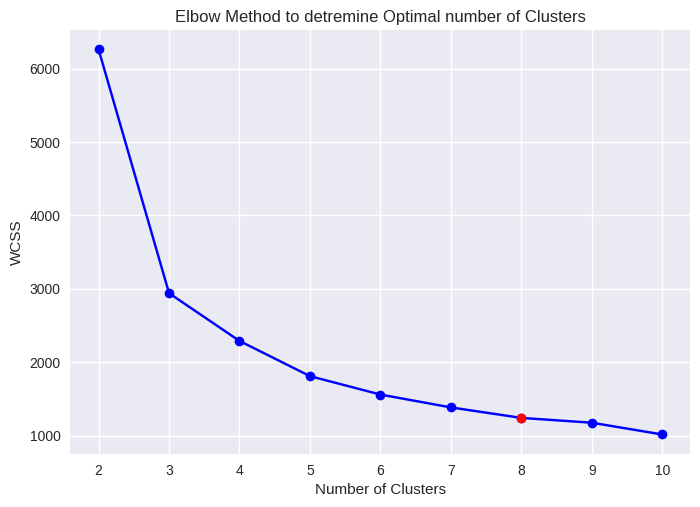

In [53]:
# Define the range of number of clusters to try
k_values = range(2, 11)
wcss = []

# Calculate the WCSS for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=17)
    kmeans.fit(user_cluster_df[selected_columns_cluster])
    wcss.append(kmeans.inertia_)

# Plot the number of clusters vs. WCSS
plt.plot(k_values, wcss, 'b-', marker='o')
plt.plot(k_values[6], wcss[6], 'ro', markerfacecolor='r', markeredgecolor='r')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to detremine Optimal number of Clusters')
plt.show()

In [60]:
# Define the number of clusters
num_clusters = 8

# Apply label encoding to selected columns
for column in selected_columns_encode:
    user_cluster_df[column] = label_encoder.fit_transform(user_cluster_df[column])

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters,n_init=10, random_state=17)
clusters = kmeans.fit_predict(user_cluster_df[selected_columns_cluster])
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
user_cluster_df['Cluster'] = cluster_labels
cluster_centroids = kmeans.cluster_centers_

# Print the resulting DataFrame with cluster labels

user_cluster_df

,Gender,Age,Type of Job,Weekly working hours,Income,openness_rating,conscientiousness_rating,extraversion_rating,agreeableness_rating,neuroticism_rating,Cluster
0,0,62,2,0,1,2.500,5.000,2.500,5.000,2.500,2
1,0,26,1,0,1,1.875,1.250,1.875,1.250,4.375,3
2,1,22,1,0,1,3.125,3.750,3.125,4.375,3.125,5
3,0,24,5,1,1,2.500,3.750,2.500,3.750,3.125,5
4,0,34,1,0,1,2.500,3.125,2.500,3.750,3.750,6
...,...,...,...,...,...,...,...,...,...,...,...
115,0,28,1,0,2,2.500,2.500,2.500,1.875,3.125,3
116,0,55,4,0,2,1.875,5.000,1.875,4.375,1.250,4
117,0,18,5,0,2,1.875,1.250,1.875,2.500,3.750,1
118,0,61,6,1,1,2.500,3.750,2.500,2.500,3.750,2


In [62]:
# Analyze the cluster centroids
for cluster_id, centroid in enumerate(cluster_centroids):
    print(f"Cluster {cluster_id + 1} centroid:")
    for feature_id, value in enumerate(centroid):
        print(f"Feature {feature_id + 1}: {value}")
    print()

Cluster 1 centroid:
Feature 1: 0.8
Feature 2: 47.8
Feature 3: 4.8
Feature 4: 0.6
Feature 5: 0.3999999999999999
Feature 6: 2.75
Feature 7: 3.25
Feature 8: 2.75
Feature 9: 3.5
Feature 10: 3.125

Cluster 2 centroid:
Feature 1: 0.22727272727272724
Feature 2: 19.409090909090907
Feature 3: 4.8181818181818175
Feature 4: 0.409090909090909
Feature 5: 1.1818181818181819
Feature 6: 2.215909090909091
Feature 7: 2.6420454545454546
Feature 8: 2.215909090909091
Feature 9: 2.869318181818182
Feature 10: 3.5511363636363638

Cluster 3 centroid:
Feature 1: 0.3333333333333333
Feature 2: 63.666666666666664
Feature 3: 4.5
Feature 4: 0.6666666666666666
Feature 5: 1.0
Feature 6: 2.6041666666666665
Feature 7: 3.75
Feature 8: 2.6041666666666665
Feature 9: 3.2291666666666665
Feature 10: 2.9166666666666665

Cluster 4 centroid:
Feature 1: 0.16666666666666666
Feature 2: 27.583333333333336
Feature 3: 1.0
Feature 4: 0.0
Feature 5: 1.5833333333333333
Feature 6: 2.96875
Feature 7: 3.75
Feature 8: 2.96875
Feature 9: 3.33

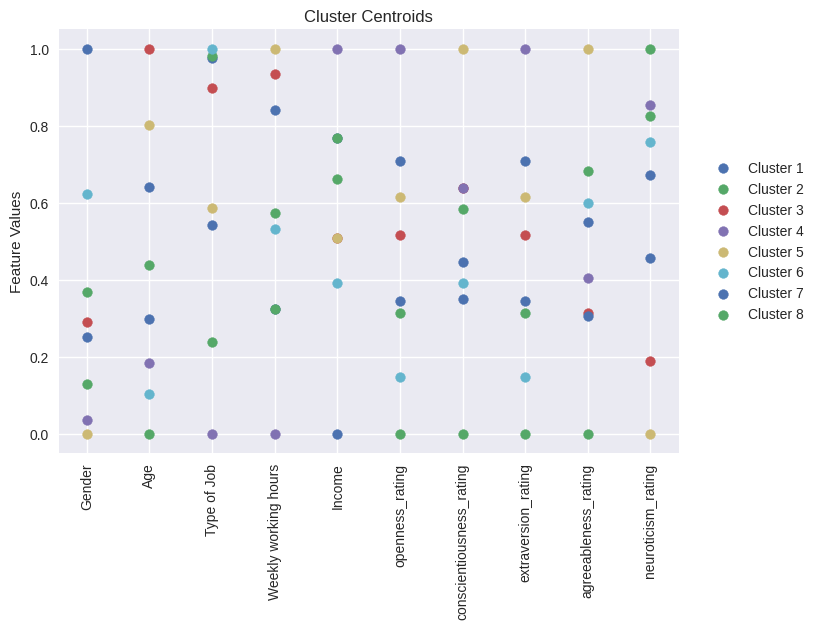

In [71]:
from sklearn.preprocessing import MinMaxScaler

# Feature labels
#feature_labels = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10']
feature_labels= ['Gender', 'Age', 'Type of Job', 'Weekly working hours', 'Income', 'openness_rating', 'conscientiousness_rating', 'extraversion_rating', 'agreeableness_rating', 'neuroticism_rating']
y = feature_labels
# Number of clusters
num_clusters = len(cluster_centroids)

# Number of features
num_features = len(feature_labels)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the cluster centroids
normalized_centroids = scaler.fit_transform(cluster_centroids)

# Generate x-axis values (feature indices) for plotting
x = range(num_features)

# Create a scatter plot
for i in range(num_clusters):
    centroid_values = normalized_centroids[i]
    plt.scatter(x, centroid_values, label=f'Cluster {i+1}')

# Set x-axis labels and tick positions
plt.xticks(x, y, rotation='vertical')

# Set y-axis label
plt.ylabel('Feature Values')

# Set plot title
plt.title('Cluster Centroids')

# Add a legend
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

# Show plot
plt.show()

# Training and Inference - All Categories


In [ ]:
person_click_df.columns

Index(['Gender', 'Age', 'Type of Job', 'Weekly working hours', 'Income',
       'openness_rating', 'conscientiousness_rating', 'extraversion_rating',
       'agreeableness_rating', 'neuroticism_rating', 'media_click_prob',
       'image_click_prob', 'text_click_prob'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

X_encoded_dfs = []
Y_media_dfs = []
Y_image_dfs = []
Y_text_dfs = []

for person_click_df in person_click_dfs:
    X = person_click_df[['Gender', 'Age', 'Type of Job', 'Weekly working hours', 'Income', 'openness_rating', 'conscientiousness_rating', 'extraversion_rating', 'agreeableness_rating', 'neuroticism_rating']].copy()

    # Encode the categorical columns
    X['Gender'] = label_encoder.fit_transform(X['Gender'])
    X['Type of Job'] = label_encoder.fit_transform(X['Type of Job'])
    X['Weekly working hours'] = label_encoder.fit_transform(X['Weekly working hours'])

    Y_media = person_click_df[['media_click_prob']].copy()
    Y_image = person_click_df[['image_click_prob']].copy()
    Y_text = person_click_df[['text_click_prob']].copy()

    Y_media_dfs.append(Y_media)
    Y_image_dfs.append(Y_image)
    Y_text_dfs.append(Y_text)
    X_encoded_dfs.append(X)


In [ ]:
#for Ydataframes in Y_image_dfs:
  #  print(Ydataframes.shape)

for Xdataframes in X_encoded_dfs:
    print(Xdataframes.shape)

(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)
(120, 10)


In [ ]:
from sklearn.model_selection import train_test_split

def split(X_encoded_dfs, Y_dfs):
    X_train_list = []
    X_val_list = []
    X_test_list = []
    Y_train_list = []
    Y_val_list = []
    Y_test_list = []

    for i in range(len(X_encoded_dfs)):
        X = X_encoded_dfs[i]
        Y = Y_dfs[i]

        X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=18, shuffle=True)
        X_val, X_test, Y_val, Y_test = train_test_split(X_test_val, Y_test_val, test_size=0.5, random_state=18, shuffle=True)

        X_train_list.append(X_train)
        X_val_list.append(X_val)
        X_test_list.append(X_test)
        Y_train_list.append(Y_train)
        Y_val_list.append(Y_val)
        Y_test_list.append(Y_test)

    return X_train_list, X_val_list, X_test_list, Y_train_list, Y_val_list, Y_test_list

X_train_list, X_val_list, X_test_list, Y_media_train_list, Y_media_val_list, Y_media_test_list = split(X_encoded_dfs, Y_media_dfs)
X_train_list, X_val_list, X_test_list, Y_image_train_list, Y_image_val_list, Y_image_test_list = split(X_encoded_dfs, Y_image_dfs)
X_train_list, X_val_list, X_test_list, Y_text_train_list, Y_text_val_list, Y_text_test_list = split(X_encoded_dfs, Y_text_dfs)

for i, df in enumerate(X_train_list):
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print(f'DataFrame {i+1}: {num_rows} rows by {num_cols} columns')

DataFrame 1: 96 rows by 10 columns
DataFrame 2: 96 rows by 10 columns
DataFrame 3: 96 rows by 10 columns
DataFrame 4: 96 rows by 10 columns
DataFrame 5: 96 rows by 10 columns
DataFrame 6: 96 rows by 10 columns
DataFrame 7: 96 rows by 10 columns
DataFrame 8: 96 rows by 10 columns
DataFrame 9: 96 rows by 10 columns
DataFrame 10: 96 rows by 10 columns
DataFrame 11: 96 rows by 10 columns
DataFrame 12: 96 rows by 10 columns
DataFrame 13: 96 rows by 10 columns
DataFrame 14: 96 rows by 10 columns
DataFrame 15: 96 rows by 10 columns
DataFrame 16: 96 rows by 10 columns
DataFrame 17: 96 rows by 10 columns
DataFrame 18: 96 rows by 10 columns
DataFrame 19: 96 rows by 10 columns
DataFrame 20: 96 rows by 10 columns


In [ ]:
Y_media_val_list[1]
#X_val_list[1]

,media_click_prob
86,1
109,1
113,0
117,0
39,0
119,0
12,1
110,0
47,1
90,0


In [ ]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_and_evaluate(X_train, Y_train, X_val, Y_val, ad_type):
    # Choose a machine learning algorithm
    model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=17)
    
    # Train the model
    model.fit(X_train, Y_train.values.ravel())

    # Evaluate the model on the val set
    Y_pred_val = model.predict(X_val)
    print(Y_pred_val)

    # Get the classification report
    report = classification_report(Y_val, Y_pred_val, zero_division=1)
    #report = 1
    # Get the coefficients from the model
    coef = 'svm'

    return model, coef, report

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_XG(X_train, Y_train, X_val, Y_val, ad_type):

    #model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    #model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, random_state=17, reg_alpha=0.01)
    model = xgb.XGBClassifier(n_estimators=10000, max_depth=6, learning_rate=0.001, random_state=17, reg_lambda=0.01)

    model.fit(X_train, Y_train)
    Y_pred_val = model.predict(X_val)

    # Evaluate the model
    accuracy = accuracy_score(Y_val, Y_pred_val)
    precision = precision_score(Y_val, Y_pred_val)
    recall = recall_score(Y_val, Y_pred_val)
    f1 = f1_score(Y_val, Y_pred_val)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Get the classification report
    report = classification_report(Y_val, Y_pred_val, zero_division=1)
    coef= 1

    return model, coef, report



In [ ]:
models_media = []
coefs_media = []
reports_media = []
Y_pred_media_val = []

for i in range(len(X_train_list)):
    X_train = X_train_list[i]
    X_val = X_val_list[i]
  
    Y_media_train = Y_media_train_list[i]
    Y_media_val = Y_media_val_list[i]
    
    model_media, coef_media, report_media = train_and_evaluate_XG(X_train, Y_media_train, X_val, Y_media_val, ad_type='Media')
    models_media.append(model_media)
    coefs_media.append(coef_media)
    reports_media.append(report_media)
    


Accuracy: 0.25
Precision: 0.2857142857142857
Recall: 0.3333333333333333
F1-score: 0.30769230769230765
Accuracy: 0.5833333333333334
Precision: 0.5
Recall: 0.4
F1-score: 0.4444444444444445


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.75
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5833333333333334
Precision: 0.6666666666666666
Recall: 0.3333333333333333
F1-score: 0.4444444444444444
Accuracy: 0.5
Precision: 0.5
Recall: 0.6666666666666666
F1-score: 0.5714285714285715
Accuracy: 0.5
Precision: 0.3333333333333333
Recall: 0.2
F1-score: 0.25
Accuracy: 0.3333333333333333
Precision: 0.16666666666666666
Recall: 0.25
F1-score: 0.2
Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5
Precision: 0.2857142857142857
Recall: 0.6666666666666666
F1-score: 0.4
Accuracy: 0.75
Precision: 0.75
Recall: 0.6
F1-score: 0.6666666666666665
Accuracy: 0.6666666666666666
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F1-score: 0.3333333333333333
Accuracy: 0.8333333333333334
Precision: 0.5
Recall: 0.5
F1-score: 0.5
Accuracy: 0.5833333333333334
Precision: 0.5
Recall: 0.4
F1-score: 0.4444444444444445
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.4
F1-score: 0.5
Accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
models_image = []
coefs_image = []
reports_image = []

for i in range(len(X_train_list)):
    X_train = X_train_list[i]
    X_val = X_val_list[i]
  
    Y_image_train = Y_image_train_list[i]
    Y_image_val = Y_image_val_list[i]

    model_image, coef_image, report_image = train_and_evaluate_XG(X_train, Y_image_train, X_val, Y_image_val, ad_type='Image')
    models_image.append(model_image)
    coefs_image.append(coef_image)
    reports_image.append(report_image)

Accuracy: 0.6666666666666666
Precision: 0.75
Recall: 0.75
F1-score: 0.75
Accuracy: 0.5
Precision: 0.6666666666666666
Recall: 0.2857142857142857
F1-score: 0.4
Accuracy: 0.25
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5
Precision: 0.5
Recall: 0.5
F1-score: 0.5
Accuracy: 0.6666666666666666
Precision: 0.8
Recall: 0.5714285714285714
F1-score: 0.6666666666666666
Accuracy: 0.4166666666666667
Precision: 0.42857142857142855
Recall: 0.5
F1-score: 0.4615384615384615
Accuracy: 0.5833333333333334
Precision: 0.3333333333333333
Recall: 0.25
F1-score: 0.28571428571428575
Accuracy: 0.5833333333333334
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5833333333333334
Precision: 0.42857142857142855
Recall: 0.75
F1-score: 0.5454545454545454
Accuracy: 0.5833333333333334
Precision: 0.4
Recall: 0.5
F1-score: 0.4444444444444445
Accuracy: 0.6666666666666666
Precision: 0.5714285714285714
Recall: 0.8
F1-score: 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.9166666666666666
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.25
Precision: 0.16666666666666666
Recall: 0.2
F1-score: 0.1818181818181818
Accuracy: 0.4166666666666667
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5833333333333334
Precision: 0.6
Recall: 0.5
F1-score: 0.5454545454545454
Accuracy: 0.5833333333333334
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.25
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5
Precision: 0.5
Recall: 0.5
F1-score: 0.5
Accuracy: 0.4166666666666667
Precision: 0.16666666666666666
Recall: 0.3333333333333333
F1-score: 0.2222222222222222
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
models_text = []
coefs_text = []
reports_text = []

for i in range(len(X_train_list)):
    X_train = X_train_list[i]
    X_val = X_val_list[i]

    Y_text_train = Y_text_train_list[i]
    Y_text_val= Y_text_val_list[i]

    model_text, coef_text, report_text = train_and_evaluate_XG(X_train, Y_text_train, X_val, Y_text_val, ad_type='Text')
    models_text.append(model_text)
    coefs_text.append(coef_text)
    reports_text.append(report_text)

Accuracy: 0.5833333333333334
Precision: 0.6
Recall: 0.5
F1-score: 0.5454545454545454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5833333333333334
Precision: 0.75
Recall: 0.42857142857142855
F1-score: 0.5454545454545454
Accuracy: 0.3333333333333333
Precision: 0.4
Recall: 0.2857142857142857
F1-score: 0.3333333333333333
Accuracy: 0.5
Precision: 0.6666666666666666
Recall: 0.5
F1-score: 0.5714285714285715
Accuracy: 0.5
Precision: 0.25
Recall: 0.25
F1-score: 0.25
Accuracy: 0.8333333333333334
Precision: 1.0
Recall: 0.3333333333333333
F1-score: 0.5
Accuracy: 0.6666666666666666
Precision: 0.6
Recall: 0.6
F1-score: 0.6
Accuracy: 0.5833333333333334
Precision: 0.5714285714285714
Recall: 0.6666666666666666
F1-score: 0.6153846153846153
Accuracy: 0.6666666666666666
Precision: 0.6
Recall: 0.6
F1-score: 0.6


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.9166666666666666
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.4166666666666667
Precision: 0.2
Recall: 0.25
F1-score: 0.22222222222222224
Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5833333333333334
Precision: 0.5714285714285714
Recall: 0.6666666666666666
F1-score: 0.6153846153846153
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Accuracy: 0.5833333333333334
Precision: 0.5
Recall: 0.8
F1-score: 0.6153846153846154
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666
Accuracy: 0.5
Precision: 0.4
Recall: 0.4
F1-score: 0.4000000000000001
Accuracy: 0.8333333333333334
Precision: 0.0
Recall: 0.0
F1-score: 0.0


In [ ]:
for i in range(len(reports_media)):
    print(f"Media - Category {i+1}:\n")
    print(reports_media[i])
    print("=" * 50)

Media - Category 1:

              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.29      0.33      0.31         6

    accuracy                           0.25        12
   macro avg       0.24      0.25      0.24        12
weighted avg       0.24      0.25      0.24        12

Media - Category 2:

              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.50      0.40      0.44         5

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12

Media - Category 3:

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.88      0.50      0.43        12
weighted av

In [ ]:
for i in range(len(reports_image)):
    print(f"Image - Category {i+1}:\n")
    print(reports_image[i])
    print("=" * 50)

Image - Category 1:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.75      0.75      0.75         8

    accuracy                           0.67        12
   macro avg       0.62      0.62      0.62        12
weighted avg       0.67      0.67      0.67        12

Image - Category 2:

              precision    recall  f1-score   support

           0       0.44      0.80      0.57         5
           1       0.67      0.29      0.40         7

    accuracy                           0.50        12
   macro avg       0.56      0.54      0.49        12
weighted avg       0.57      0.50      0.47        12

Image - Category 3:

              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.00      0.00      0.00         4

    accuracy                           0.25        12
   macro avg       0.21      0.19      0.20        12
weighted av

In [ ]:
for i in range(len(reports_text)):
    print(f"Image - Category {i+1}:\n")
    print(reports_text[i])
    print("=" * 50)

Image - Category 1:

              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.60      0.50      0.55         6

    accuracy                           0.58        12
   macro avg       0.59      0.58      0.58        12
weighted avg       0.59      0.58      0.58        12

Image - Category 2:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.83      0.50      0.40        12
weighted avg       0.78      0.67      0.53        12

Image - Category 3:

              precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.00      0.00      0.00         5

    accuracy                           0.50        12
   macro avg       0.27      0.43      0.33        12
weighted av

In [ ]:
from sklearn.metrics import accuracy_score

def predict(models, coefs, X_test_list, Y_test_list):
    predictions = []
    accuracies = []
    precisions = []
    recalls = []

    for i in range(len(models)):
        model = models[i]
        coef = coefs[i]
        X_test = X_test_list[i]
        Y_test = Y_test_list[i]

        # Perform predictions using the trained model
        Y_pred = model.predict(X_test)

        # Append the predictions to the list
        predictions.append(Y_pred)

        # Calculate accuracy
        accuracy = accuracy_score(Y_test, Y_pred)
        accuracies.append(accuracy)
        
        # Calculate precision
        precision = precision_score(Y_test, Y_pred)
        precisions.append(precision)

        # Calculate recall
        recall = recall_score(Y_test, Y_pred)
        recalls.append(recall)

    return accuracies, recalls, predictions


accuracies_media_val, recalls_media_val, predictions_media_val = predict(models_media, coefs_media, X_val_list, Y_media_val_list)
accuracies_image_val, recalls_image_val, predictions_image_val = predict(models_image, coefs_image, X_val_list, Y_image_val_list)
accuracies_text_val, recalls_text_val, predictions_text_val = predict(models_text, coefs_text, X_val_list, Y_text_val_list)

predictions_media_val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/

[array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]),
 array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
 array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]),
 array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]),
 array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]),
 array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]),
 array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [ ]:
accuracies_media_val

[0.25,
 0.5833333333333334,
 0.75,
 0.5833333333333334,
 0.5,
 0.5,
 0.3333333333333333,
 0.6666666666666666,
 0.5,
 0.75,
 0.6666666666666666,
 0.8333333333333334,
 0.5833333333333334,
 0.6666666666666666,
 0.4166666666666667,
 0.5833333333333334,
 0.25,
 0.5,
 0.5833333333333334,
 0.9166666666666666]

In [ ]:
#accuracies_media, predictions_media_test = predict(models_media, coefs_media, X_test_list, Y_media_test_list)
#accuracies_image, predictions_image_test = predict(models_image, coefs_image, X_test_list, Y_image_test_list)
#accuracies_text, predictions_text_test = predict(models_text, coefs_text, X_test_list, Y_text_test_list)

accuracies_media_test, recalls_media_test, predictions_media_test = predict(models_media, coefs_media, X_test_list, Y_media_val_list)
accuracies_image_test, recalls_image_test, predictions_image_test = predict(models_image, coefs_image, X_test_list, Y_image_val_list)
accuracies_text_test, recalls_text_test, predictions_text_test = predict(models_text, coefs_text, X_test_list, Y_text_test_list)


accuracies_media_test

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/

[0.4166666666666667,
 0.5,
 0.75,
 0.5,
 0.5,
 0.6666666666666666,
 0.75,
 0.8333333333333334,
 0.8333333333333334,
 0.75,
 0.75,
 0.8333333333333334,
 0.6666666666666666,
 0.6666666666666666,
 0.3333333333333333,
 0.5833333333333334,
 0.5833333333333334,
 0.6666666666666666,
 0.9166666666666666,
 0.9166666666666666]

In [ ]:
Y_text_val_list[1]

,text_click_prob
86,1
109,1
113,0
117,0
39,0
119,0
12,0
110,1
47,1
90,0


In [ ]:
ground_truth_media = pd.concat(Y_media_test_list, axis=1)
ground_truth_media = ground_truth_media.to_numpy()
ground_truth_media= ground_truth_media.transpose().tolist()
pd.DataFrame(ground_truth_media)
ground_truth_media

ground_truth_image = pd.concat(Y_image_test_list, axis=1)
ground_truth_image = ground_truth_image.to_numpy()
ground_truth_image= ground_truth_image.transpose().tolist()
pd.DataFrame(ground_truth_image)
ground_truth_image

ground_truth_text = pd.concat(Y_text_test_list, axis=1)
ground_truth_text = ground_truth_text.to_numpy()
ground_truth_text= ground_truth_text.transpose().tolist()
pd.DataFrame(ground_truth_text)
ground_truth_text

[[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]

In [ ]:
all_accuracy_df = pd.DataFrame()
all_recalls_df = pd.DataFrame()
#all_accuracy_df['accuracy_media'] = accuracies_media
#all_accuracy_df['accuracy_image'] = accuracies_image
#all_accuracy_df['accuracy_text'] = accuracies_text
#all_accuracy_df

all_accuracy_df['accuracy_media'] = [round(acc, 2) for acc in accuracies_media_test]
all_accuracy_df['accuracy_image'] = [round(acc, 2) for acc in accuracies_image_test]
all_accuracy_df['accuracy_text'] = [round(acc, 2) for acc in accuracies_text_test]

all_recalls_df['recalls_media'] = [round(acc, 2) for acc in recalls_media_test]
all_recalls_df['recalls_image'] = [round(acc, 2) for acc in recalls_image_test]
all_recalls_df['recalls_text'] = [round(acc, 2) for acc in recalls_text_test]


# Remap the values of predictions_media from -1 and 1 to 0 and 1
pred_media_remap = [(pred + 1) // 2 for pred in predictions_media_test]
pred_image_remap = [(pred + 1) // 2 for pred in predictions_image_test]
pred_text_remap = [(pred + 1) // 2 for pred in predictions_text_test]

print(len(pred_media_remap))
print(len(pred_image_remap))
print(len(pred_text_remap))

sum_pred_media = [np.sum(arr) for arr in pred_media_remap]
sum_pred_image = [np.sum(arr) for arr in pred_image_remap]
sum_pred_text = [np.sum(arr) for arr in pred_text_remap]
print(sum_pred_media)

all_predictions_df = pd.DataFrame()
all_predictions_df['raw_clicks_media'] = predictions_media_test
all_predictions_df['clicks_media'] = sum_pred_media
all_predictions_df['clicks_image'] = sum_pred_image
all_predictions_df['clicks_text'] = sum_pred_text
all_predictions_df

all_actual_df = pd.DataFrame()
all_actual_df['raw_clicks_media'] = ground_truth_media
sum_true_media = [np.sum(arr) for arr in ground_truth_media]
all_actual_df['true_clicks_media'] = sum_true_media

#all_actual_df['raw_clicks_image'] = ground_truth_image
sum_true_image = [np.sum(arr) for arr in ground_truth_image]
all_actual_df['true_clicks_image'] = sum_true_image

#all_actual_df['raw_clicks_text'] = ground_truth_text
sum_true_text = [np.sum(arr) for arr in ground_truth_text]
all_actual_df['true_clicks_text'] = sum_true_text

all_accuracy_df

20
20
20
[3, 1, 0, 2, 6, 3, 5, 2, 3, 4, 0, 0, 5, 1, 1, 1, 4, 1, 4, 0]


,accuracy_media,accuracy_image,accuracy_text
0,0.42,0.50,0.58
1,0.50,0.42,0.75
2,0.75,0.83,0.58
3,0.50,0.67,0.42
4,0.50,0.50,0.67
5,0.67,0.50,0.50
6,0.75,0.67,0.33
7,0.83,0.83,0.92
8,0.83,0.75,0.83
9,0.75,0.67,0.58


In [ ]:
all_predictions_df

,raw_clicks_media,clicks_media,clicks_image,clicks_text
0,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]",3,6,5
1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,0,3
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,2,2
3,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]",2,2,2
4,"[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]",6,5,4
5,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]",3,2,3
6,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]",5,4,5
7,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]",2,1,2
8,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]",3,1,4
9,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]",4,2,6


In [ ]:
Y_media_val_list

[     media_click_prob
 86                  1
 109                 1
 113                 1
 117                 1
 39                  0
 119                 0
 12                  1
 110                 0
 47                  1
 90                  0
 30                  0
 0                   0,
      media_click_prob
 86                  1
 109                 1
 113                 0
 117                 0
 39                  0
 119                 0
 12                  1
 110                 0
 47                  1
 90                  0
 30                  1
 0                   0,
      media_click_prob
 86                  1
 109                 1
 113                 0
 117                 0
 39                  0
 119                 0
 12                  0
 110                 0
 47                  1
 90                  0
 30                  0
 0                   0,
      media_click_prob
 86                  1
 109                 1
 113                 1
 117    

In [ ]:
#Remap to actual category names
all_accuracy_df['category'] = ['Clothing & Shoes', 'Automotive', 'Baby Products', 'Health & Beauty',
                 'Media (BMVD)', 'Consumer Electronics', 'Console & Video Games',
                 'DIY & Tools', 'Garden & Outdoor living', 'Grocery', 'Kitchen & Home',
                 'Betting', 'Jewellery & Watches', 'Musical Instruments', 'Office Products',
                 'Pet Supplies', 'Computer Software', 'Sports & Outdoors', 'Toys & Games',
                 'Dating Sites']

category_column = all_accuracy_df.pop('category')
# Move the "category" column as the first column
all_accuracy_df.insert(0, 'category', category_column)
          
#all_accuracy_df

In [ ]:
# Create the Accuracy bar plot
fig = px.bar(all_accuracy_df, x='category', y= ['accuracy_media', 'accuracy_image', 'accuracy_text'], color_discrete_sequence=px.colors.qualitative.Safe, barmode='group', text_auto=True)

fig.update_layout(xaxis_title='Category', yaxis_title='Accuracy', title='Accuracy per Category for Different Ad Types')
fig.show()

In [ ]:
all_recalls_df

,recalls_media,recalls_image,recalls_text
0,0.17,0.50,0.50
1,0.00,0.00,0.50
2,0.00,0.50,0.20
3,0.17,0.33,0.00
4,0.50,0.43,0.50
5,0.40,0.17,0.29
6,0.75,0.50,0.20
7,0.50,0.33,1.00
8,0.67,0.25,1.00
9,0.60,0.25,0.60


In [ ]:
all_recalls_df['category'] = all_accuracy_df['category']
category_column = all_recalls_df.pop('category')
# Move the "category" column as the first column
all_recalls_df.insert(0, 'category', category_column)

# Create the Recall bar plot
fig = px.bar(all_recalls_df, x='category', y=['recalls_media', 'recalls_image', 'recalls_text'], color_discrete_sequence=px.colors.qualitative.Safe, barmode='group', text_auto=True)


fig.update_layout(xaxis_title='Category', yaxis_title='Accuracy', title='Recall per Category for Different Ad Types')
fig.show()

In [ ]:
# Create the Click rate dataframe
all_predictions_df['category'] = all_accuracy_df['category']

category_column = all_predictions_df.pop('category')
# Move the "category" column as the first column
all_predictions_df.insert(0, 'category', category_column)
          
all_predictions_df

,category,raw_clicks_media,clicks_media,clicks_image,clicks_text
0,Clothing & Shoes,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]",3,6,5
1,Automotive,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,0,3
2,Baby Products,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,2,2
3,Health & Beauty,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]",2,2,2
4,Media (BMVD),"[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]",6,5,4
5,Consumer Electronics,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]",3,2,3
6,Console & Video Games,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]",5,4,5
7,DIY & Tools,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]",2,1,2
8,Garden & Outdoor living,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]",3,1,4
9,Grocery,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]",4,2,6


In [ ]:
# Create the staggered bar plot
fig = px.bar(all_predictions_df, x='category', y= ['clicks_media', 'clicks_image', 'clicks_text'], color_discrete_sequence=px.colors.qualitative.Safe, barmode='group')
fig.update_layout(xaxis_title='Category', yaxis_title='Clicks', title='Predicted Clicks per Category for Different Ad Types')
fig.show()

In [ ]:
# Create the Click rate dataframe
all_actual_df['category'] = all_accuracy_df['category']
category_column = all_actual_df.pop('category')
# Move the "category" column as the first column
all_actual_df.insert(0, 'category', category_column)
          
all_actual_df

,category,raw_clicks_media,true_clicks_media,true_clicks_image,true_clicks_text
0,Clothing & Shoes,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]",6,5,4
1,Automotive,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]",2,2,4
2,Baby Products,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]",3,3,5
3,Health & Beauty,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]",3,4,5
4,Media (BMVD),"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]",6,5,6
5,Consumer Electronics,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]",4,2,7
6,Console & Video Games,"[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]",4,4,5
7,DIY & Tools,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]",2,2,1
8,Garden & Outdoor living,"[0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]",4,1,2
9,Grocery,"[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]",4,3,5


In [ ]:
# Create the staggered bar plot
fig = px.bar(all_actual_df, x='category', y= ['true_clicks_media', 'true_clicks_image', 'true_clicks_text'], color_discrete_sequence=px.colors.qualitative.Safe, barmode='group')
fig.update_layout(xaxis_title='Category', yaxis_title='Clicks', title='Actual Clicks per Category for Different Ad Types', bargroupgap=0.2, bargap=0.1)
fig.show()

In [ ]:
import plotly.subplots as sp
# Create subplots with shared y-axis
#fig2 = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Predicted Clicks', 'Actual Clicks'), horizontal_spacing=0.0)
#fig2 = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Predicted Clicks', 'Actual Clicks'), horizontal_spacing=0.0, row_heights=[1], vertical_spacing=1)
fig2 = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Predicted Clicks', 'Actual Clicks'), horizontal_spacing=0.0)

# Create the actual clicks staggered bar plot
actual_fig = px.bar(all_actual_df, y='category', x=['true_clicks_media', 'true_clicks_image', 'true_clicks_text'], color_discrete_sequence=px.colors.qualitative.Safe)

# Create the predicted clicks staggered bar plot
predicted_fig = px.bar(all_predictions_df, y='category', x=['clicks_media', 'clicks_image', 'clicks_text'], color_discrete_sequence=px.colors.qualitative.Safe)

# Update the x-values to negative values
predicted_fig.data[0].x = -predicted_fig.data[0].x
predicted_fig.data[1].x = -predicted_fig.data[1].x
predicted_fig.data[2].x = -predicted_fig.data[2].x

fig2.add_trace(actual_fig.data[0], row=1, col=2)
fig2.add_trace(actual_fig.data[1], row=1, col=2)
fig2.add_trace(actual_fig.data[2], row=1, col=2)

# Add the predicted click bar plot to the subplot
fig2.add_trace(predicted_fig.data[0], row=1, col=1)
fig2.add_trace(predicted_fig.data[1], row=1, col=1)
fig2.add_trace(predicted_fig.data[2], row=1, col=1)

fig2.update_traces(width=0.2)

fig2.update_layout(yaxis_title='Category', xaxis_title='Clicks', title='Clicks per Category for Different Ad Types',
                    bargap=0.5, bargroupgap=0, width=1500, barmode='group',
                    height=900)
fig2.show()

In [ ]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Create subplots with shared y-axis
#fig2 = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Predicted Clicks', 'Actual Clicks'), horizontal_spacing=0.0)
#fig2 = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Predicted Clicks', 'Actual Clicks'), horizontal_spacing=0.0, row_heights=[1], vertical_spacing=1)
fig2 = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Predicted Clicks', 'Actual Clicks'), vertical_spacing=0, horizontal_spacing=0)

# Create the actual clicks staggered bar plot
actual_fig = px.bar(all_actual_df, y='category', x=['true_clicks_media', 'true_clicks_image', 'true_clicks_text'] , color_discrete_sequence=px.colors.qualitative.Safe, text_auto=True)

# Create the predicted clicks staggered bar plot
predicted_fig = px.bar(all_predictions_df, y='category', x=['clicks_media', 'clicks_image', 'clicks_text'], color_discrete_sequence=px.colors.qualitative.Safe, text_auto=True)

# Update the x-values to negative values
predicted_fig.data[0].x = -predicted_fig.data[0].x
predicted_fig.data[1].x = -predicted_fig.data[1].x
predicted_fig.data[2].x = -predicted_fig.data[2].x

# Add the actual click bar plot to the subplot
fig2.add_trace(actual_fig.data[0], row=1, col=2)
fig2.add_trace(actual_fig.data[1], row=1, col=2)
fig2.add_trace(actual_fig.data[2], row=1, col=2)

# Calculate the total clicks for each category
actual_total_clicks = all_actual_df['true_clicks_media'] + all_actual_df['true_clicks_image'] + all_actual_df['true_clicks_text']
predicted_total_clicks = all_predictions_df['clicks_media'] + all_predictions_df['clicks_image'] + all_predictions_df['clicks_text']
predicted_total_clicks = -predicted_total_clicks
fig2.add_trace(go.Scatter(x=actual_total_clicks, y=all_actual_df['category'], mode='text', text=actual_total_clicks, textposition='top left', showlegend=False), row=1, col=2)

# Add the predicted click bar plot to the subplot
fig2.add_trace(predicted_fig.data[0], row=1, col=1)
fig2.add_trace(predicted_fig.data[1], row=1, col=1)
fig2.add_trace(predicted_fig.data[2], row=1, col=1)
fig2.add_trace(go.Scatter(x=predicted_total_clicks, y=all_predictions_df['category'], mode='text', text=predicted_total_clicks, textposition='top left', showlegend=False), row=1, col=1)

#fig2.update_traces(width=0.4)

fig2.update_layout(yaxis_title='Category', xaxis_title='Clicks', title='Clicks per Category for Different Ad Types',
                    bargap=0.5, bargroupgap=0.1, width=1500, barmode='stack',
                    height=900)
fig2.show()